In [1]:
library(ggplot2)
library(cowplot)
library(vegan)
library(dunn.test)


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-2


In [2]:
asv_tab <- read.table("data/asv_table.tab", comment.char="", header=1, skip=1, sep="\t", row.names=1)
pd <- read.table("data/faith_pd_vector.tsv", sep="\t", header=1)
md <- read.table("data/METADATA.txt", header=1, comment.char="", sep="\t", row.names=1)
taxonomy <- read.table("data/taxonomy.tsv", sep="\t", header=1, row.names=1)

colnames(pd) <- c("SampleID", "PD")
pd$Location <- md[as.character(pd$SampleID),"location"]
pd$Location <- as.factor(pd$Location)
levels(pd$Location) <- c("Palmetto Inland (n=6)", "Palmetto Coast (n=6)", "Vero Beach (n=4)")
#Swap the order
pd$Location <- factor(pd$Location,levels(pd$Location)[c(2,1,3)])

In [3]:
cut_taxonomy_string <- function(x, n) {
    sp <- unlist(strsplit(x,";"))
    if (length(sp) >= n) {
        return(sp[n])
        }
    else {
        return(sp[length(sp)])
    }
}

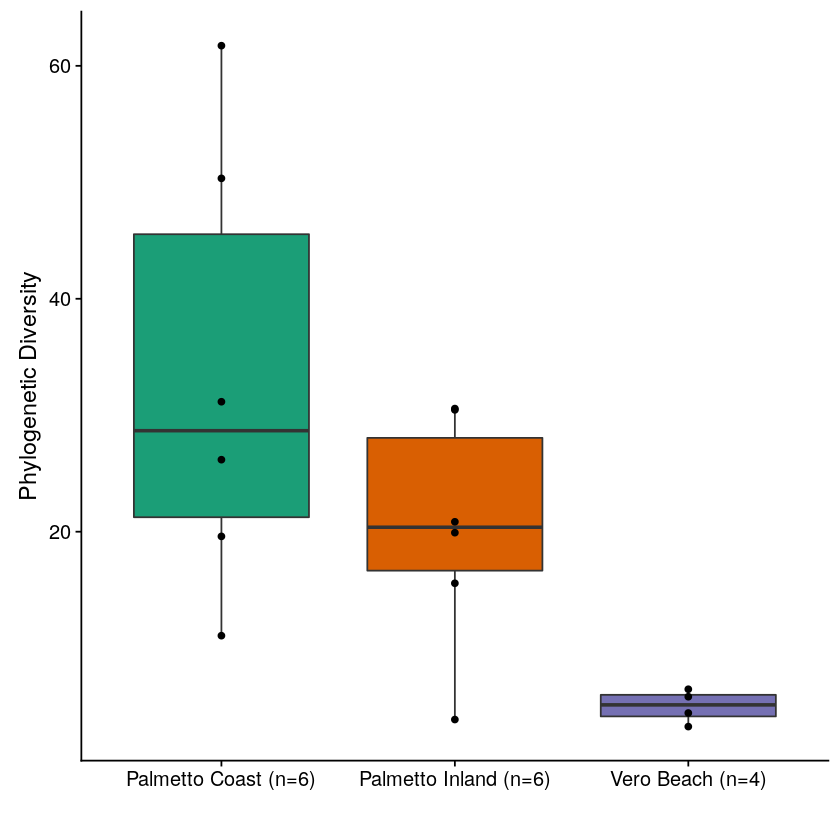

In [4]:
ad <- ggplot(pd, aes(x=Location, group=Location, y=PD, fill=Location)) + geom_boxplot() + geom_point() +
scale_fill_brewer(palette='Dark2') + theme(legend.position='none') + ylab("Phylogenetic Diversity") +
xlab("")

ad

In [5]:
plot_ordination <- function(ord) {
    md.vars <- md[gsub('X','',colnames(asv_tab)),]
    md.vars$location <- as.factor(md.vars$location)
    levels(md.vars$location) <- c("Palmetto Inland", "Palmetto Coast", "Vero Beach")

    md.tax <- taxonomy[rownames(asv_tab),]
    topn <- 10
    top <- match(as.character(names(rowSums(asv_tab)[1:topn])), as.character(rownames(asv_tab)))
    tax_labels <- unlist(
                  lapply(as.character(
                         taxonomy[names(rowSums(asv_tab)[1:topn]), 'Taxon']
                         ), 
                        function(x) cut_taxonomy_string(x, 7)
                        )
                        )
    plot(ord, display='sites')
    ordilabel(ord, display = "spec", cex=0.45, col="black", border=FALSE, select=top, labels=tax_labels, xpd = FALSE)
    ordispider(ord, md.vars$location, col=c("#d95f02","#1b9e77","#7570b3"), label=FALSE)
    ordiellipse(ord, md.vars$location, col=c("#d95f02","#1b9e77","#7570b3"), draw='polygon')
}

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1849418 
Run 1 stress 0.1849418 
... Procrustes: rmse 4.207153e-06  max resid 8.270168e-06 
... Similar to previous best
Run 2 stress 0.1849418 
... Procrustes: rmse 1.430446e-05  max resid 2.662685e-05 
... Similar to previous best
Run 3 stress 0.1849418 
... Procrustes: rmse 1.848336e-05  max resid 4.746783e-05 
... Similar to previous best
Run 4 stress 0.2188532 
Run 5 stress 0.1841978 
... New best solution
... Procrustes: rmse 0.02430507  max resid 0.0758766 
Run 6 stress 0.2211664 
Run 7 stress 0.1909601 
Run 8 stress 0.1909601 
Run 9 stress 0.2172943 
Run 10 stress 0.2500873 
Run 11 stress 0.2294799 
Run 12 stress 0.1909601 
Run 13 stress 0.1841978 
... New best solution
... Procrustes: rmse 1.35019e-05  max resid 2.435786e-05 
... Similar to previous best
Run 14 stress 0.2204758 
Run 15 stress 0.1909604 
Run 16 stress 0.1849418 
Run 17 stress 0.2343784 
Run 18 stress 0.1905837 
Run 19 stress 0.1909601 
R

Warning message in postMDS(out$points, dis, plot = max(0, plot - 1), ...):
“skipping half-change scaling: too few points below threshold”


Call:
metaMDS(comm = t(asv_tab), distance = "bray", binary = TRUE) 

global Multidimensional Scaling using monoMDS

Data:     wisconsin(sqrt(t(asv_tab))) 
Distance: binary bray 

Dimensions: 2 
Stress:     0.1841978 
Stress type 1, weak ties
Two convergent solutions found after 20 tries
Scaling: centring, PC rotation 
Species: expanded scores based on ‘wisconsin(sqrt(t(asv_tab)))’ 


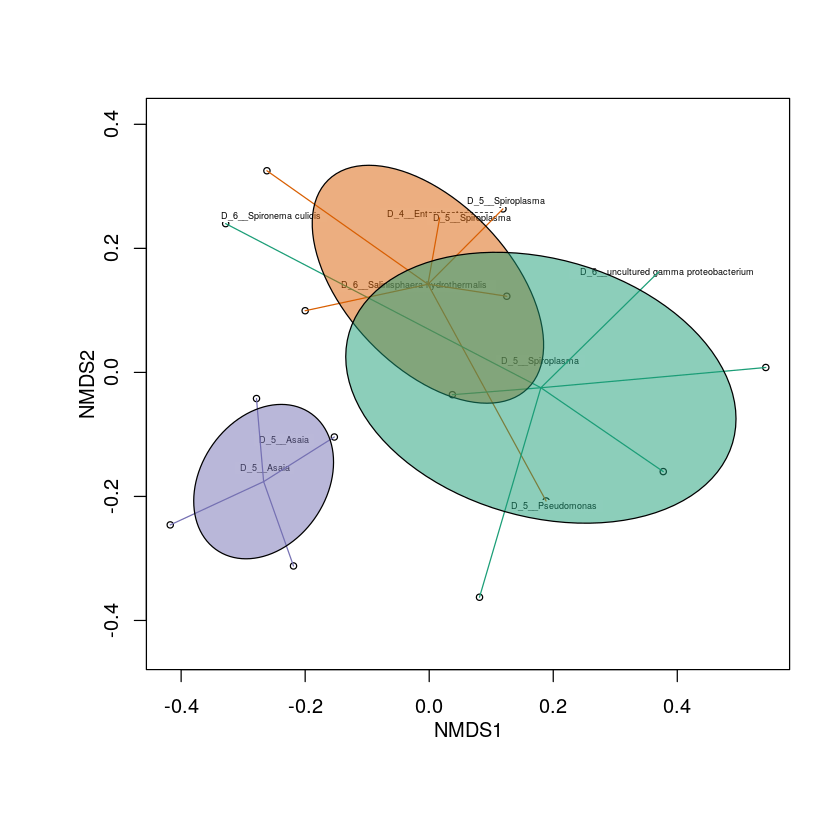

In [6]:
par(xpd = NA, # switch off clipping, necessary to always see axis labels
    bg = "transparent", # switch off background to avoid obscuring adjacent plots
    oma = c(2, 2, 0, 0), # move plot to the right and up
    mgp = c(2, 1, 0) # move axis labels closer to axis
)
uwb <- metaMDS(t(asv_tab), dist='bray', binary=TRUE)
uwb
plot_ordination(uwb)
puwb <- recordPlot()

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1792614 
Run 1 stress 0.1993312 
Run 2 stress 0.1792615 
... Procrustes: rmse 2.440062e-05  max resid 4.894592e-05 
... Similar to previous best
Run 3 stress 0.2595857 
Run 4 stress 0.2587638 
Run 5 stress 0.2890028 
Run 6 stress 0.1792614 
... Procrustes: rmse 1.617467e-05  max resid 2.815451e-05 
... Similar to previous best
Run 7 stress 0.1993312 
Run 8 stress 0.2618557 
Run 9 stress 0.2709108 
Run 10 stress 0.2710359 
Run 11 stress 0.2458875 
Run 12 stress 0.2256444 
Run 13 stress 0.1792614 
... New best solution
... Procrustes: rmse 1.879089e-05  max resid 3.256585e-05 
... Similar to previous best
Run 14 stress 0.1792614 
... New best solution
... Procrustes: rmse 9.893331e-06  max resid 1.80804e-05 
... Similar to previous best
Run 15 stress 0.1792614 
... New best solution
... Procrustes: rmse 5.492465e-06  max resid 9.419797e-06 
... Similar to previous best
Run 16 stress 0.2938402 
Run 17 stress 0.2547

Warning message in postMDS(out$points, dis, plot = max(0, plot - 1), ...):
“skipping half-change scaling: too few points below threshold”


Call:
metaMDS(comm = t(asv_tab), distance = "bray", binary = FALSE) 

global Multidimensional Scaling using monoMDS

Data:     wisconsin(sqrt(t(asv_tab))) 
Distance: bray 

Dimensions: 2 
Stress:     0.1792614 
Stress type 1, weak ties
Two convergent solutions found after 20 tries
Scaling: centring, PC rotation 
Species: expanded scores based on ‘wisconsin(sqrt(t(asv_tab)))’ 


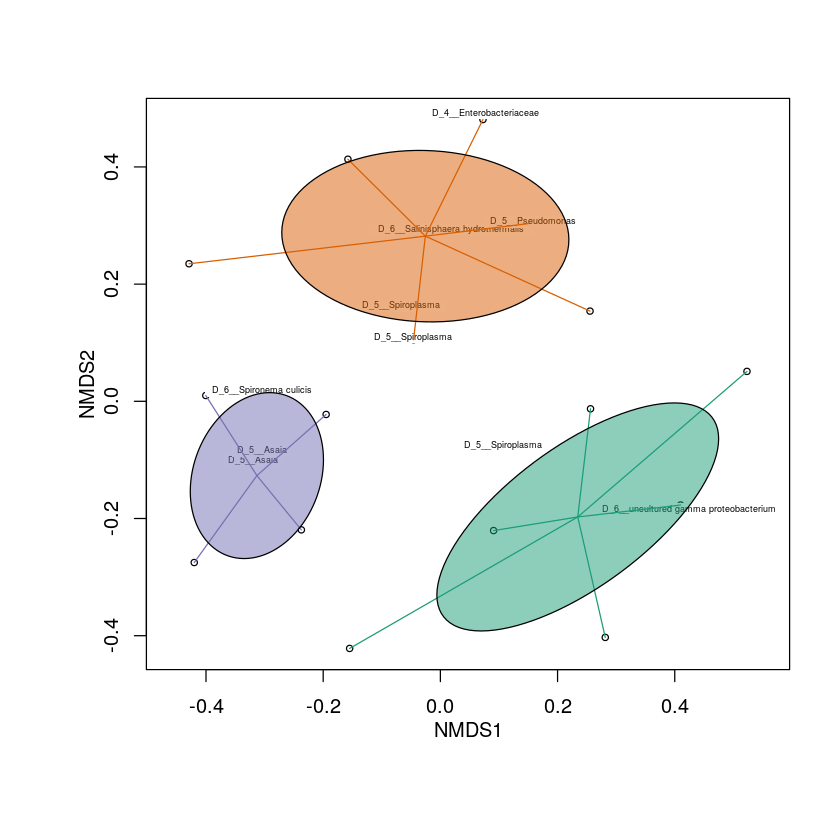

In [7]:
par(xpd = NA, # switch off clipping, necessary to always see axis labels
    bg = "transparent", # switch off background to avoid obscuring adjacent plots
    oma = c(2, 2, 0, 0), # move plot to the right and up
    mgp = c(2, 1, 0) # move axis labels closer to axis
)
wb <- metaMDS(t(asv_tab), dist='bray', binary=FALSE)
wb
plot_ordination(wb)
pwb <- recordPlot()

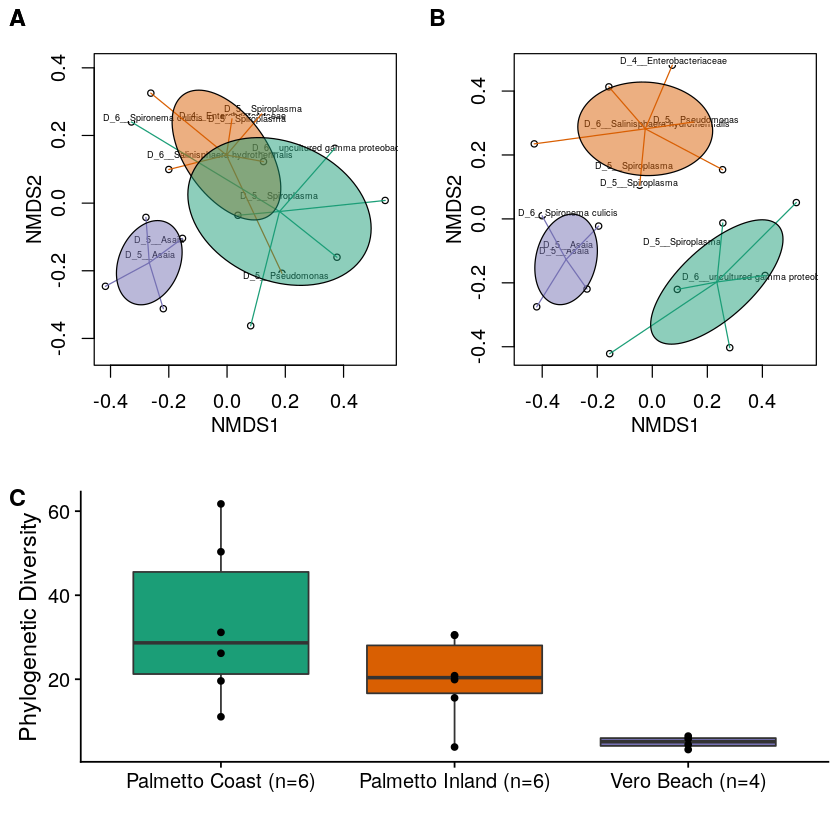

In [8]:
options(plot.repr.width=5, plot.repr.height=5)
plot_grid(plot_grid(puwb, pwb, ncol=2, labels=c("A","B")), ad, nrow=2, rel_heights = c(1,0.75), labels=c("A","C"))

In [9]:
print(dunn.test(pd$PD, pd$Location))

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 7.5478, df = 2, p-value = 0.02


                           Comparison of x by group                            
                                (No adjustment)                                
Col Mean-|
Row Mean |   Palmetto   Palmetto
---------+----------------------
Palmetto |   1.030776
         |     0.1513
         |
Vero Bea |   2.738747   1.816792
         |    0.0031*     0.0346

alpha = 0.05
Reject Ho if p <= alpha/2
$chi2
[1] 7.547794

$Z
[1] 1.030776 2.738747 1.816793

$P
[1] 0.15132284 0.00308369 0.03462444

$P.adjusted
[1] 0.15132284 0.00308369 0.03462444

$comparisons
[1] "Palmetto Coast (n=6) - Palmetto Inland (n=6)"
[2] "Palmetto Coast (n=6) - Vero Beach (n=4)"     
[3] "Palmetto Inland (n=6) - Vero Beach (n=4)"    

